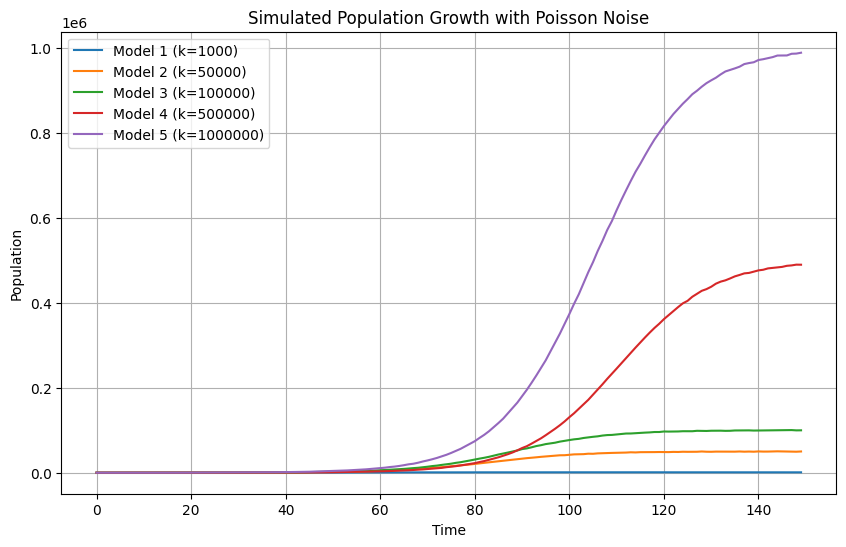

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def growthEQ(t, y):
    r = 0.1
    return r*y*(1 - (y/carrying_cap))

num_of_models = 5
time = 150
states = [5, 12, 15, 8, 27]
k_vals = [1000, 50_000, 100_000, 500_000, 1_000_000]
data = np.empty([5, time])


for i in range(num_of_models):
    if len(states) != num_of_models or len(k_vals) != num_of_models:
        print("Either initial states or k_vals does not equal the number of models.")
        exit()

    init_state = [states[i]]
    carrying_cap = k_vals[i]
    sol = solve_ivp(fun=growthEQ, 
                    t_span=[0, time], 
                    y0=init_state, 
                    t_eval=range(time))
    data[i] = np.random.poisson(sol.y[0])


# Save to CSV
file_path = '../datasets/resample_experiment_time_series.csv'
df = pd.DataFrame(data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(k_vals)])
df.to_csv(file_path, index=False)


# Create plot for data 
plt.figure(figsize=(10, 6))
for i in range(num_of_models):
    plt.plot(np.arange(time), data[i], label=f'Model {i+1} (k={k_vals[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

## Increasing the rate

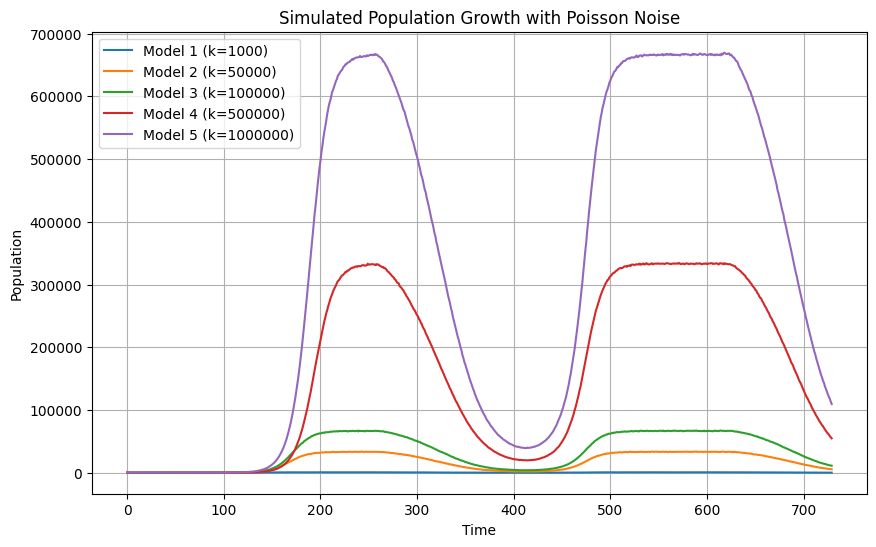

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd


d=365
t=np.linspace(0,2*d,2*d+1)
def effBeta(t):
    return 0.1*(1.2-np.cos(t/d*2*np.pi))


def growthEQ(t, y):
    r = min(effBeta(t), 0.15)
    mu = 0.05
    return r*y*(1 - (y/carrying_cap)) - mu*y

num_of_models = 5
time = 730
states = [5, 12, 15, 8, 27]
k_vals = [1000, 50_000, 100_000, 500_000, 1_000_000]
data = np.empty([num_of_models, time])


for i in range(num_of_models):
    if len(states) != num_of_models or len(k_vals) != num_of_models:
        print("Either initial states or k_vals does not equal the number of models.")
        exit()

    init_state = [states[i]]
    carrying_cap = k_vals[i]
    sol = solve_ivp(fun=growthEQ, 
                    t_span=[0, time], 
                    y0=init_state, 
                    t_eval=range(time))
    data[i] = np.random.poisson(sol.y[0])


# Save to CSV
file_path = '../datasets/resample_experiment_time_series.csv'
df = pd.DataFrame(data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(k_vals)])
df.to_csv(file_path, index=False)


# Create plot for data 
plt.figure(figsize=(10, 6))
for i in range(num_of_models):
    plt.plot(np.arange(time), data[i], label=f'Model {i+1} (k={k_vals[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
'''Entry point for the particle filtering code '''

import sys
sys.path.append('../')
import numpy as np

from Implementations.algorithms.TimeDependentBeta import TimeDependentAlgo
from Implementations.algorithms.Experiment import ExperimentAlgo
from Implementations.resamplers.resamplers import PoissonResample,NBinomResample, LogNBinomResampleExperiment
from Implementations.solvers.DeterministicSolvers import LSODACalvettiSolver,LSODASolverExperiment,LSODASolverSEIARHD, EulerSolverExperiment
from Implementations.perturbers.perturbers import LogMultivariatePerturbations, ExperimentPerturb
from utilities.Utils import Context,ESTIMATION
from functools import partial


'''Algorithm object encapsulating all the requirements

The integrator is an object which runs the t->t+1 propagation of the particles, primarily using the LSODA 
integrator built in to scipy.integrate(solve_ivp)

The perturb object performs multivariate perturbations on the state variables and the estimated variables

The resampler computes the weights and resamples based on a known algorithm(multinomial,systematic,residual)



'''
algo = ExperimentAlgo(integrator = LSODASolverExperiment(),
                        perturb = ExperimentPerturb(hyper_params={'sigma':0.1}),
                        resampler = LogNBinomResampleExperiment(),
                        ctx=Context(population=30,
                                    state_size = 5,
                                    weights=np.zeros(1000),
                                    seed_loc=[0,1,2,3,4],
                                    seed_size=100,
                                    forward_estimation=1,
                                    rng=np.random.default_rng(1),
                                    particle_count=100))

algo.initialize(params={
"r": ESTIMATION.VARIABLE,
"k": 3,
"mu": 0.05,
"R": 50
}
,priors={
"r": partial(algo.ctx.rng.uniform, 0, 0.01),
"k": partial(algo.ctx.rng.uniform, 1000, 100000),
"mu": partial(algo.ctx.rng.uniform, 0, 1)
})

'''Runs the PF over the specified data set for the specified length of time'''
for particle in algo.particles:
    particle.param["k"] = np.array([1000, 50_000, 100_000, 500_000, 1_000_000])
#algo.print_particles()
algo.run(f'../datasets/resample_experiment_time_series.csv',365)


Iteration: 0
0.004829717740947888
Iteration: 1
0.004784374194929601
Iteration: 2
0.004862128041483328
Iteration: 3
0.004907891294815235
Iteration: 4
0.00479754383637051
Iteration: 5
0.004893770403022066
Iteration: 6
0.00494384025211604
Iteration: 7
0.005003342765974459
Iteration: 8
0.004862701266133506
Iteration: 9
0.004906678293762077
Iteration: 10
0.004874569679670601
Iteration: 11
0.004959127406386396
Iteration: 12
0.0050318223451075415
Iteration: 13
0.005091372433412948
Iteration: 14
0.0051599677247097875
Iteration: 15
0.0051713484913931285
Iteration: 16
0.005292100151536946
Iteration: 17
0.005258525941564572
Iteration: 18
0.0052312646462319085
Iteration: 19
0.0053461508149094
Iteration: 20
0.005319792400898968
Iteration: 21
0.005307756852486212
Iteration: 22
0.005343556094740492
Iteration: 23
0.0053462923337815405
Iteration: 24
0.005384033889822318
Iteration: 25
0.005438663124817018
Iteration: 26
0.005481580342460396
Iteration: 27
0.0054584890296975755
Iteration: 28
0.005420180895

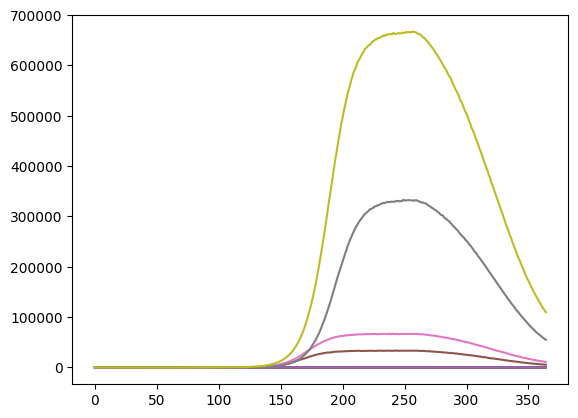

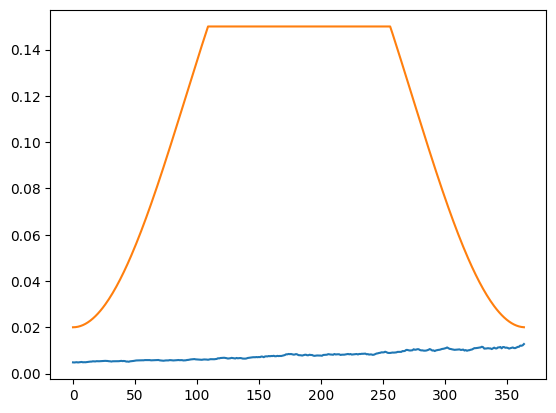

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

pf_state = pd.read_csv('../datasets/state_quantiles.csv').to_numpy()
pf_state = np.delete(pf_state,0,1)
pf_r = pd.read_csv('../datasets/r_quantiles.csv').to_numpy()
pf_r = np.delete(pf_r,0,1)

real_data = pd.read_csv('../datasets/resample_experiment_time_series.csv').to_numpy()
real_data = np.delete(real_data,0,1)

d=365
t=np.linspace(0,2*d,2*d+1)
def effBeta(t):
    return 0.1*(1.2-np.cos(t/d*2*np.pi))

r_vals = [min(effBeta(t), 0.15) for t in range(365)]

plt.plot(pf_state)
plt.plot(real_data[:365])
plt.show()
plt.plot(pf_r)
plt.plot(r_vals)